# Membrane Proteome Paper, Figures and Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2
#from ete4 import Tree

In [2]:
#Update rcParams to use the Roboto COndensed font instead of the default DejaVu Sans
plt.rcParams.update({'font.family':'sans-serif'})
COLOR_BLIND = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']

### Figure 1: Description of what the Asgard membrane proteome is

#### Venn Diagram/ Comparison of TMBed and DeepTMHMM predictions

In [3]:
#Filepaths
#Transmembrane protein prediction files
tm_folder = '/stor/work/Marcotte/project/drbarth/asgard/membrane_proteome/data/raw/tm_predictions/'
all_prots_deep = tm_folder + 'D4994_C39_H1_asgardbins.fasta.deeptmhmm.3line'
all_prots_tmbed = tm_folder + 'D4994_C39_H1_asgardbins.fasta.tmbed.3lines'

In [4]:
#Function to parse through 3lines files for either deeptmhmm or tmbed format: 
def read3line(filepath, format):    
    protein_names = []
    sequence = []
    prediction = []
    with open(filepath, "r") as a_file:
        for line in a_file:
            if line.startswith('>'):
                #split_line = line.strip('\n')
                split_line = line.split('>')
                if format == 'tmbed':
                    split_line = split_line[1].split('\n')
                elif format == 'deeptmhmm':
                    split_line = split_line[1].split(' ')
                prot_name = split_line[0]
                protein_names.append(prot_name)
                for a in range(2):
                    if a == 0:
                        seq = next(a_file)
                        split = seq.split('\n')
                        sequence.append(split[0])
                    else: 
                        pred = next(a_file)
                        pred_split = pred.split('\n')
                        prediction.append(pred_split[0])
    df = pd.DataFrame(list(zip(protein_names, sequence, prediction)),
               columns =['ProteinID', 'aa_sequence', format+'_prediction'])
    return df

In [5]:
deep_df = read3line(all_prots_deep, 'deeptmhmm')
tmbed_df = read3line(all_prots_tmbed, 'tmbed')

In [6]:
tmbed_df.head()

,ProteinID,aa_sequence,tmbed_prediction
0,D4994_C39_H1_Bin_33_scaffold_101747_1,MITRSRGNESRSFNRSTSPNSRSSSSSRSNLDSDSDSDSDSYSNDI...,iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...
1,D4994_C39_H1_Bin_33_scaffold_101747_2,MEEYLIHKGPVSCWDEKTKGEVIALMYHKIIVTVEWYKKNPTNEEF...,iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...
2,D4994_C39_H1_Bin_33_scaffold_101747_3,MKPQFFIGNNVYAMIKAFTKNNKTQGVLTVVPNTVRPDKICSGRFM...,iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...
3,D4994_C39_H1_Bin_33_scaffold_102981_1,MKKNTFTVVTLSVLVLAVMIPMTFPGNDTRVEDQVAMQPDAPVTSY...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSoooooooooo...
4,D4994_C39_H1_Bin_33_scaffold_102981_10,MVEEEREDREEEEGEEGEEEEEGDNLGELVDGGITEDNLANVTGDD...,iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...


In [7]:
#If I want to translate TMBed to DeepTMHMM, TMBed has more info encoded than DeepTMHMM so we'll have to flop this way... Here are the flips: 
# i : I, o : O, S stays as S, B : M, b : M, H : M, and h : M 
tmbed_to_deep_dict = {'i':'I', 'o':'O', 'S':'S', 'B':'M', 'b':'M', 'H':'M', 'h':'M'}

#Make a new dataframe where tmbed_df's tmbed_prediction column is translated to DeepTMHMM's format
tmbed_asdeep_df = tmbed_df.copy()

#A function that will split the column into strings and translate each of the strings
def translate_tmbed_to_deep(tmbed_prediction):
    tmbed_prediction = list(tmbed_prediction)
    tmbed_prediction = [tmbed_to_deep_dict[tmbed_prediction[i]] for i in range(len(tmbed_prediction))]
    tmbed_prediction = ''.join(tmbed_prediction)
    return tmbed_prediction


tmbed_asdeep_df['tmbed_prediction'] = tmbed_asdeep_df['tmbed_prediction'].map(translate_tmbed_to_deep)
tmbed_asdeep_df.head()


,ProteinID,aa_sequence,tmbed_prediction
0,D4994_C39_H1_Bin_33_scaffold_101747_1,MITRSRGNESRSFNRSTSPNSRSSSSSRSNLDSDSDSDSDSYSNDI...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
1,D4994_C39_H1_Bin_33_scaffold_101747_2,MEEYLIHKGPVSCWDEKTKGEVIALMYHKIIVTVEWYKKNPTNEEF...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
2,D4994_C39_H1_Bin_33_scaffold_101747_3,MKPQFFIGNNVYAMIKAFTKNNKTQGVLTVVPNTVRPDKICSGRFM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
3,D4994_C39_H1_Bin_33_scaffold_102981_1,MKKNTFTVVTLSVLVLAVMIPMTFPGNDTRVEDQVAMQPDAPVTSY...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOO...
4,D4994_C39_H1_Bin_33_scaffold_102981_10,MVEEEREDREEEEGEEGEEEEEGDNLGELVDGGITEDNLANVTGDD...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [8]:
#Now we can compare the predictions properly
#Merge deep_df and tmbed_df
#Drop the aa_seq column from tmbed_df
tmbed_df_tomerge = tmbed_asdeep_df.drop(['aa_sequence'], axis=1)

tm_preds = deep_df.merge(tmbed_df_tomerge, on='ProteinID', how='left')
tm_preds.head()



,ProteinID,aa_sequence,deeptmhmm_prediction,tmbed_prediction
0,D4994_C39_H1_Bin_33_scaffold_101747_1,MITRSRGNESRSFNRSTSPNSRSSSSSRSNLDSDSDSDSDSYSNDI...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
1,D4994_C39_H1_Bin_33_scaffold_101747_2,MEEYLIHKGPVSCWDEKTKGEVIALMYHKIIVTVEWYKKNPTNEEF...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
2,D4994_C39_H1_Bin_33_scaffold_101747_3,MKPQFFIGNNVYAMIKAFTKNNKTQGVLTVVPNTVRPDKICSGRFM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
3,D4994_C39_H1_Bin_33_scaffold_102981_1,MKKNTFTVVTLSVLVLAVMIPMTFPGNDTRVEDQVAMQPDAPVTSY...,SSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOO...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOO...
4,D4994_C39_H1_Bin_33_scaffold_102981_10,MVEEEREDREEEEGEEGEEEEEGDNLGELVDGGITEDNLANVTGDD...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [9]:
print(f'There are: {tmbed_df_tomerge.shape[0]} proteins in the tmbed dataset and {deep_df.shape[0]} in the deeptmhmm dataset.')

There are: 50979 proteins in the tmbed dataset and 50979 in the deeptmhmm dataset.


In [10]:
#How can I compare the two outputs here?
# I could do an alignment of the two outputs and see how much overlap there is? But that might be a bit deeper than necessary right now. 
# How about first, let's go through and determine the number of transmembrane residues in each protein. -- essentially if an M is present
# Then I think it would be cool to see if there are any Signal Peptides predicted as well 
def num_tm_residues(seq):
    """
    This function takes a sequence and returns the number of transmembrane residues in the sequence
    """
    tm_residues = 0
    l = len(seq)
    for i in range(1,l):
        prev = seq[i-1]
        residue = seq[i]
        if residue == 'M':
            if prev != 'M':
                tm_residues += 1
            elif tm_residues == 0:
                tm_residues += 1
    return tm_residues

In [11]:
def num_signal_peptides(seq):
    """Return the number of signal peptides in a sequence."""
    signal_peptides = 0
    l = len(seq)
    for i in range(1,l):
        prev = seq[i-1]
        residue = seq[i]
        if residue == 'S':
            if prev != 'S':
                signal_peptides += 1
            elif signal_peptides == 0:
                signal_peptides += 1
    return signal_peptides

In [12]:
#Apply the num_tm_residues function to the dataframe
#df['num_tm_residues'] = df['sequence'].apply(num_tm_residues)
tm_preds['num_tm_residues_deep'] = tm_preds['deeptmhmm_prediction'].apply(num_tm_residues)
tm_preds['num_signal_deep'] = tm_preds['deeptmhmm_prediction'].apply(num_signal_peptides)

tm_preds['num_tm_residues_tmbed'] = tm_preds['tmbed_prediction'].apply(num_tm_residues)
tm_preds['num_signal_tmbed'] = tm_preds['tmbed_prediction'].apply(num_signal_peptides)

tm_preds.head()

,ProteinID,aa_sequence,deeptmhmm_prediction,tmbed_prediction,num_tm_residues_deep,num_signal_deep,num_tm_residues_tmbed,num_signal_tmbed
0,D4994_C39_H1_Bin_33_scaffold_101747_1,MITRSRGNESRSFNRSTSPNSRSSSSSRSNLDSDSDSDSDSYSNDI...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,1,0,1,0
1,D4994_C39_H1_Bin_33_scaffold_101747_2,MEEYLIHKGPVSCWDEKTKGEVIALMYHKIIVTVEWYKKNPTNEEF...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,0,0
2,D4994_C39_H1_Bin_33_scaffold_101747_3,MKPQFFIGNNVYAMIKAFTKNNKTQGVLTVVPNTVRPDKICSGRFM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,0,0
3,D4994_C39_H1_Bin_33_scaffold_102981_1,MKKNTFTVVTLSVLVLAVMIPMTFPGNDTRVEDQVAMQPDAPVTSY...,SSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOO...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOO...,1,1,1,1
4,D4994_C39_H1_Bin_33_scaffold_102981_10,MVEEEREDREEEEGEEGEEEEEGDNLGELVDGGITEDNLANVTGDD...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,0,0


In [13]:
tm_preds['deeptmhmm_prediction'][4]

'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'

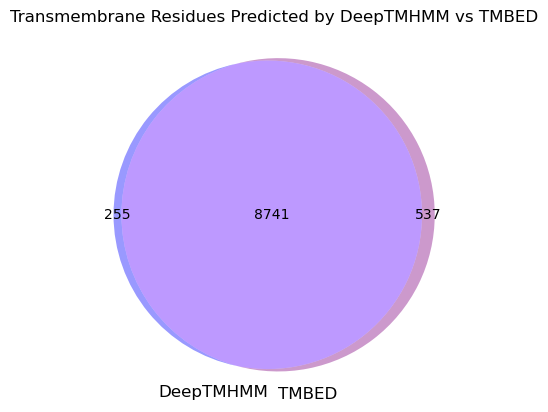

In [14]:
#Plot a Venn Diagram Comparing the num_tm_resides predicted by deeptmhmm vs tmbed
from matplotlib_venn import venn2

#Get number of proteins predicted to have TM regions by DeepTMHMM
deep_predicted_tms = tm_preds[tm_preds['num_tm_residues_deep'] != 0]
tmbed_predicted_tms = tm_preds[tm_preds['num_tm_residues_tmbed'] != 0]

#Create a venn diagram comparing the two
venn2([set(deep_predicted_tms['ProteinID']), set(tmbed_predicted_tms['ProteinID'])], set_labels = ('DeepTMHMM', 'TMBED'), set_colors=('blue', 'purple'))
plt.title('Transmembrane Residues Predicted by DeepTMHMM vs TMBED')
plt.show()


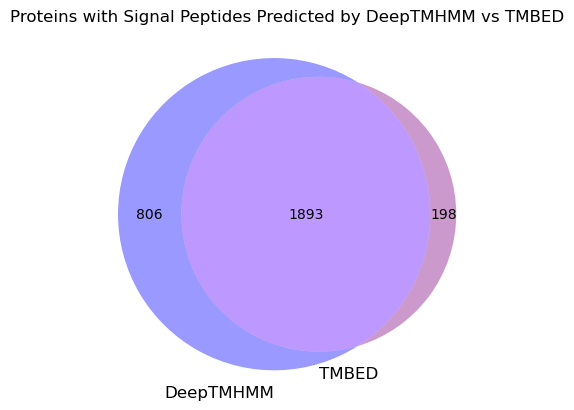

In [15]:
#Create a venn diagram comparing the signal peptides predicted by DeepTMHMM and TMBED
deep_predicted_signals = tm_preds[tm_preds['num_signal_deep'] != 0]
tmbed_predicted_signals = tm_preds[tm_preds['num_signal_tmbed'] != 0]

venn2([set(deep_predicted_signals['ProteinID']), set(tmbed_predicted_signals['ProteinID'])], set_labels = ('DeepTMHMM', 'TMBED'), set_colors=('blue', 'purple'))
plt.title('Proteins with Signal Peptides Predicted by DeepTMHMM vs TMBED')
plt.show()

In [16]:
deep_predicted_tms = tm_preds[tm_preds['num_tm_residues_deep'] != 0]
deep_predicted_tms.shape[0]

8996

In [17]:
#Use tm_preds to build dataframe for the circular barplot
#Get counts for each of the stats I'm interested in per condition 
deep_predicted_tms = tm_preds[tm_preds['num_tm_residues_deep'] != 0] 
deep_tms_only = tm_preds[(tm_preds['num_tm_residues_deep'] != 0) & (tm_preds['num_signal_deep'] == 0)]
tmbed_tms_only = tm_preds[(tm_preds['num_tm_residues_tmbed'] != 0) & (tm_preds['num_signal_tmbed'] == 0)]
tmbed_predicted_tms = tm_preds[tm_preds['num_tm_residues_tmbed'] != 0]
deep_predicted_signals = tm_preds[tm_preds['num_signal_deep'] != 0]
deep_signal_tms = tm_preds[(tm_preds['num_signal_deep'] != 0) & (tm_preds['num_tm_residues_deep'] != 0)]
deep_signal_notms = tm_preds[(tm_preds['num_signal_deep'] != 0) & (tm_preds['num_tm_residues_deep'] == 0)]
tmbed_predicted_signals = tm_preds[tm_preds['num_signal_tmbed'] != 0]
tmbed_signal_tms = tm_preds[(tm_preds['num_signal_tmbed'] != 0) & (tm_preds['num_tm_residues_tmbed'] != 0)]
tmbed_signal_notms = tm_preds[(tm_preds['num_signal_tmbed'] != 0) & (tm_preds['num_tm_residues_tmbed'] == 0)]

#need the number of total proteins in the dataset to calculate the percentage of proteins with TM regions
#Actually I think my total count should come from the full pool -- I should have a venn diagram showing the proportion of the full proteome (or maybe heat map for each bin) and then for the deeptmhmm vs tmbed it should be this circular thing
#showing totals of proportions of the total predicted for TMBed and the total predicted for DeepTMHMM. I could then take the higher number of those and use that as proportion for the circular graph... just like this because it shows overlap better instead of needing like 4-5 Venn diagrams...

#Find the total number of found tmrs + proteins by deeptmhmm -- all of the only signal proteins, all of the tmrs only, and all of the signal + tmrs
found_tmsp_deep = deep_signal_notms.shape[0] + deep_tms_only.shape[0] + deep_signal_tms.shape[0]
found_tmsp_tmbed = tmbed_signal_notms.shape[0] + tmbed_tms_only.shape[0] + tmbed_signal_tms.shape[0]
print(f'The total number of proteins with TM regions predicted by DeepTMHMM is: {found_tmsp_deep} and the total number of proteins with TM regions predicted by TMBED is: {found_tmsp_tmbed}, the number of proteins found via DeepTMHMM is higher, so we will use that as the total')

#Find the total number of found tmrs + proteins by tmbed


total_proteins = tm_preds.shape[0]
print(total_proteins)

conditions_list = [deep_signal_notms.shape[0], deep_signal_tms.shape[0], deep_predicted_signals.shape[0], deep_predicted_tms.shape[0], tmbed_signal_notms.shape[0], tmbed_signal_tms.shape[0], tmbed_predicted_signals.shape[0], tmbed_predicted_tms.shape[0]]


models_dict = {'models': ['DeepTMHMM','DeepTMHMM','DeepTMHMM','DeepTMHMM', 'TMBed','TMBed','TMBed','TMBed'], 
            'conditions': ["SPnoTMRs", "TMRs+SP", "SP", "TMRs", "SPnoTMRs", "TMRs+SP", "SP", "TMRs"], 
            'proportion':[(x/total_proteins) for x in conditions_list]}
models_df = pd.DataFrame(models_dict)
models_df['percentage'] = models_df['proportion'].apply(lambda x: x*100)
models_df



The total number of proteins with TM regions predicted by DeepTMHMM is: 10493 and the total number of proteins with TM regions predicted by TMBED is: 10206, the number of proteins found via DeepTMHMM is higher, so we will use that as the total
50979


,models,conditions,proportion,percentage
0,DeepTMHMM,SPnoTMRs,0.029365,2.936503
1,DeepTMHMM,TMRs+SP,0.023578,2.357834
2,DeepTMHMM,SP,0.052943,5.294337
3,DeepTMHMM,TMRs,0.176465,17.646482
4,TMBed,SPnoTMRs,0.018204,1.820357
5,TMBed,TMRs+SP,0.022813,2.281332
6,TMBed,SP,0.041017,4.101689
7,TMBed,TMRs,0.181997,18.199651


In [23]:
conditions_list
secretory_deep = deep_signal_notms.drop(['aa_sequence', 'deeptmhmm_prediction', 'num_tm_residues_deep', 'num_tm_residues_tmbed', 'num_signal_tmbed'], axis=1)
secretory_tmbed = tmbed_signal_notms.drop(['aa_sequence', 'tmbed_prediction', 'num_tm_residues_deep', 'num_tm_residues_tmbed', 'num_signal_deep'], axis=1)
secretory_union = secretory_deep.merge(secretory_tmbed, on='ProteinID', how='outer')
secretory_union.head(20)
#secretory_union = secretory_union[secretory_union['deeptmhmm_prediction_x'].isnull() | secretory_union['deeptmhmm_prediction_y'].isnull()]

,ProteinID,tmbed_prediction,num_signal_deep,deeptmhmm_prediction,num_signal_tmbed
0,D4994_C39_H1_Bin_33_scaffold_111262_11,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOO...,1.0,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOO...,1.0
1,D4994_C39_H1_Bin_33_scaffold_115175_4,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,1.0,NaN,NaN
2,D4994_C39_H1_Bin_33_scaffold_115175_7,SSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,1.0,SSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,1.0
3,D4994_C39_H1_Bin_33_scaffold_125873_6,SSSSSIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMOOOOOOOOO...,1.0,NaN,NaN
4,D4994_C39_H1_Bin_33_scaffold_128324_6,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,1.0,NaN,NaN
5,D4994_C39_H1_Bin_33_scaffold_140309_1,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOO...,1.0,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOO...,1.0
6,D4994_C39_H1_Bin_33_scaffold_140309_4,IIIIIIIIIIIIIIIOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,1.0,NaN,NaN
7,D4994_C39_H1_Bin_33_scaffold_140309_8,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOO...,1.0,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOO...,1.0
8,D4994_C39_H1_Bin_33_scaffold_14647_17,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOO...,1.0,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOO...,1.0
9,D4994_C39_H1_Bin_33_scaffold_14647_41,IIIIIIIIIIIIIIOMMMMMIIIIIIIIIIIIIIIIOMMMMMIIII...,1.0,NaN,NaN


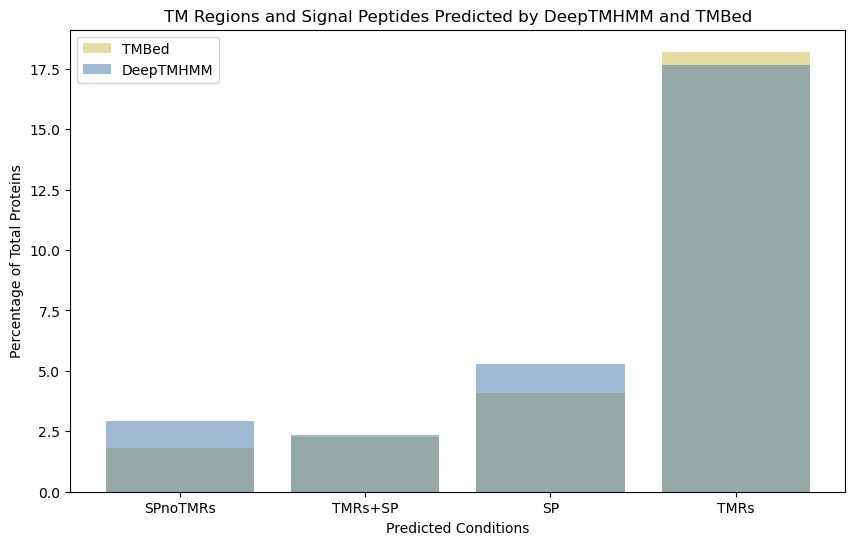

In [35]:
#Let's try a bar chart here instead of these 4 conditions and DeepTMHMM overlaid on TMBed
#I think I want to do a stacked bar chart here
#I want to have the proportions of each of the conditions for DeepTMHMM and TMBed
# Plot histograms
plt.figure(figsize=(10, 6))  # Optional: adjust the figure size

#Filter tm_preds to only include proteins that have a non-zero value in num_tm_residues_deep and num_tm_re
bed_prop = models_df[models_df['models'] == 'TMBed']
deep_prop = models_df[models_df['models'] == 'DeepTMHMM']
# Plot bar charts
plt.bar(bed_prop['conditions'], bed_prop['percentage'], alpha=0.5, label='TMBed', color=COLOR_BLIND[3])
plt.bar(deep_prop['conditions'], deep_prop['percentage'], alpha=0.5, label='DeepTMHMM', color=COLOR_BLIND[0])

plt.xlabel('Predicted Conditions')
# Make x-axis cut off at 30
#plt.xlim(0, 25)
plt.ylabel('Percentage of Total Proteins')
plt.title('TM Regions and Signal Peptides Predicted by DeepTMHMM and TMBed')
plt.legend()
plt.show()

In [100]:
#Maybe we could do one of those circular bar graphs here and have, number of TMRs, number of signal peptides, number of TMRs and signal, number of only signal and not TMR with a bar for each of the two predictors
#HUGE thank you to this tutorial: https://python-graph-gallery.com/web-heatmap-and-radial-barchart-plastics/
#Auxiliary function that takes a circular axis object and applies some styles and customizations
def style_polar_axis(ax):
    # Change the initial location of the 0 in radians
    ax.set_theta_offset(np.pi / 2)
    
    # Move in clock-wise direction 
    ax.set_theta_direction(-1)

    # Remove all spines
    ax.set_frame_on(False)

    # Don't use tick labels for radial axis
    ax.set_xticklabels([])
    
    # Set limits for y axis
    ax.set_ylim([0, 4.5])
    # Set ticks for y axis. These determine the grid lines.
    ax.set_yticks([0, 1, 2, 3, 4, 4.5])
    # But don't use tick labels
    ax.set_yticklabels([])
    
    # Set grid with some transparency
    ax.grid(alpha=0.4)

    return ax

In [104]:
#This function takes an axis and a color, and adds the labels corresponding to each line in each circular plot
def add_labels_polar_axis(ax, color):
    # Define the characteristics of the bbox behind the text we add
    bbox_dict = {
        "facecolor": "w", "edgecolor": color, "linewidth": 1, 
        "boxstyle": "round", "pad": 0.10
    }
    condition_types = ["tmr", "allsp", "tmr+sp", "sp"]
    start = len(condition_types)
    # Iterate over types of plastics and add the labels
    for idx, condition in enumerate(condition_types):
        ax.text(
            0, start - idx, condition, color=color, ha="center", va="center",
            fontsize=9, bbox=bbox_dict
        )
        print(start-idx)
    return ax

In [109]:
#This function creates the circular bar plot
def plot_circular(axes):
    # Flatten the axes object, gets a 1D array that IDs the plots designated by the plt.subplots() output, only doing this for one graph so don't really need it! 
    #axes_flattened = axes.ravel()
    models = models_df["models"].unique()
    print(models)
    # Adjust style of the plot
    ax = style_polar_axis(axes)
    print(ax)
    
    for i, model in enumerate(models):
        # Select data for the given company
        #Here we need to select the conditions for either DeepTMHMM or TMBED I think... So we need a grouped df with TMBed and DeepTMHMM as the rows and the columns as the conditions 
        d = models_df[models_df["models"] == model]
        print(d)
        # Select plot
        #ax = axes_flattened #[i]
        print(ax)

        # add label for vertical axis
       # if i == 0:
        #    ax.set_ylabel("Protein Predictions", loc="top")

        # Adjust style of the plot
        #ax = style_polar_axis(axes)
        #print(ax)

        # Multiply the proportion by the 2pi, the complete rotation 
        proportions = d['proportions'].values * (2 * np.pi)
        print(proportions)

        # Positions for the lines on the radial
        y_pos = np.arange(1,len(proportions)+1)
        y_deep = y_pos + 0.2
        y_tmbed = y_pos - 0.2
        y_i = [y_deep, y_tmbed]

        # Construct the line for each type of plastic creating a grid for the x and y values
        x = np.linspace(0, proportions, num=200)
        print(x)
        y = np.vstack([y_i[i]] * 200)
        print(y)
        # Select color
        color = COLOR_BLIND[i]

        # And finally, plot the rounded lines
        ax.plot(x, y[i], lw=6, color=color, solid_capstyle="round")

        # Add title
        ax.set_title(model, pad=10, color="0.3")

        # Add labels on top of the lines
        ax = add_labels_polar_axis(ax, color)
    return axes

['DeepTMHMM' 'TMBed']
PolarAxesSubplot(0.125,0.11;0.775x0.77)
      models conditions  proportions
0  DeepTMHMM   SPnoTMRs     0.142667
1  DeepTMHMM    TMRs+SP     0.114553
2  DeepTMHMM         SP     0.257219
3  DeepTMHMM       TMRs     0.857333
PolarAxesSubplot(0.125,0.11;0.775x0.77)
[ 0.89640031  0.71975495  1.61615526  5.386785  ]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.50452415e-03   3.61685907e-03   8.12138322e-03   2.70692714e-02]
 [  9.00904830e-03   7.23371814e-03   1.62427664e-02   5.41385427e-02]
 [  1.35135724e-02   1.08505772e-02   2.43641496e-02   8.12078141e-02]
 [  1.80180966e-02   1.44674363e-02   3.24855329e-02   1.08277085e-01]
 [  2.25226207e-02   1.80842953e-02   4.06069161e-02   1.35346357e-01]
 [  2.70271449e-02   2.17011544e-02   4.87282993e-02   1.62415628e-01]
 [  3.15316690e-02   2.53180135e-02   5.68496825e-02   1.89484900e-01]
 [  3.60361932e-02   2.89348725e-02   6.49710657e-02   2.16554171e-01]
 [  4.05407173e-02   3.2

ValueError: x and y must have same first dimension, but have shapes (200, 4) and (4,)

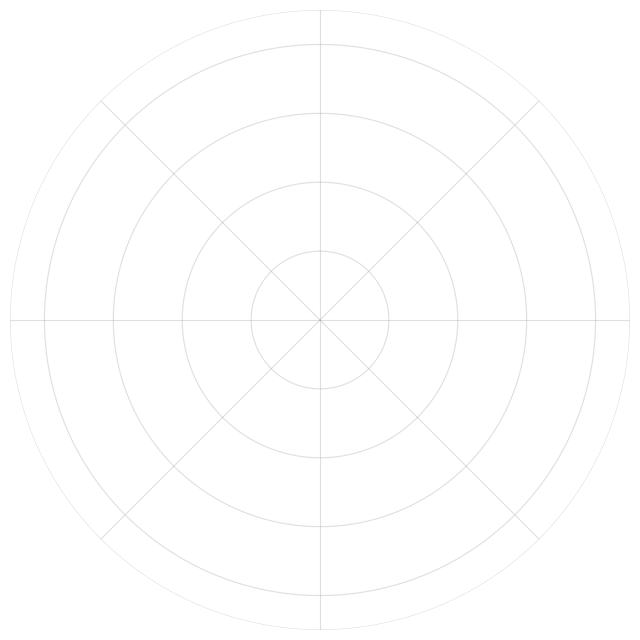

In [110]:
#Plot! Initialize layout
fig, axes = plt.subplots(1, 1, figsize=(8, 12), subplot_kw={"projection": "polar"})

#fig, axes = plt.subplots(3, 2, figsize=(8, 12), subplot_kw={"projection": "polar"})

# Create chart! 
axes = plot_circular(axes)

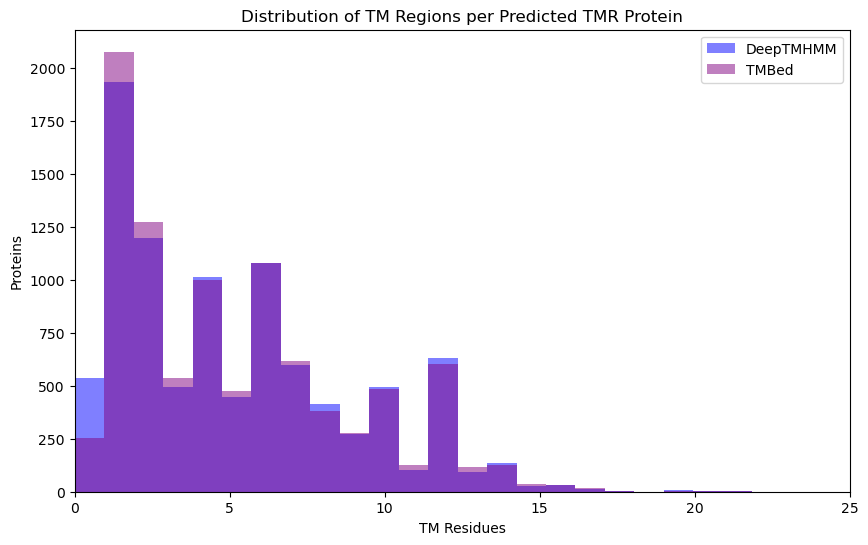

In [15]:
# Plot histogram of the distribution of the number of TMR residues per protein predicted by deeptmhmm and tmbed
#Plot a histogram with two columns
# 1. Number of TMR residues predicted by deeptmhmm
# 2. Number of TMR residues predicted by tmbed

# Plot histograms
plt.figure(figsize=(10, 6))  # Optional: adjust the figure size

#Filter tm_preds to only include proteins that have a non-zero value in num_tm_residues_deep and num_tm_residues_tmbed
tm_preds_TMRs = tm_preds[(tm_preds['num_tm_residues_deep'] > 0) | (tm_preds['num_tm_residues_tmbed'] > 0)]

# Plot histogram for column1
plt.hist(tm_preds_TMRs['num_tm_residues_deep'], bins=100, alpha=0.5, label='DeepTMHMM', color='blue')

# Plot histogram for column2
plt.hist(tm_preds_TMRs['num_tm_residues_tmbed'], bins=100, alpha=0.5, label='TMBed', color='purple')

plt.xlabel('TM Residues')
# Make x-axis cut off at 30
plt.xlim(0, 25)
plt.ylabel('Proteins')
plt.title('Distribution of TM Regions per Predicted TMR Protein')
plt.legend()

plt.show()



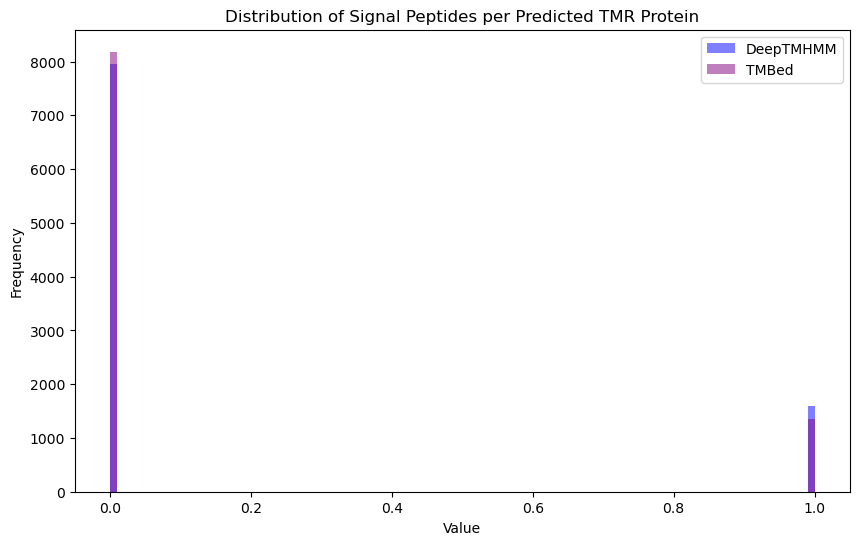

In [16]:
# Only 1 signaling region is ever predicted per protein 
# Let's look at the proportion of the proteins with TMRs that also have signals -- this is better as a bar plot
# Plot histogram of the distribution of the number of signal residues per protein predicted by deeptmhmm and tmbed
# Plot histograms
plt.figure(figsize=(10, 6))  # Optional: adjust the figure size

# Plot histogram for column1
plt.hist(tm_preds_TMRs['num_signal_deep'], bins=100, alpha=0.5, label='DeepTMHMM', color='blue')

# Plot histogram for column2
plt.hist(tm_preds_TMRs['num_signal_tmbed'], bins=100, alpha=0.5, label='TMBed', color='purple')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Signal Peptides per Predicted TMR Protein')
plt.legend()

plt.show()












#### Connecting in the reference archaea predictions

In [17]:
#Filepaths
#Other archaea transmembrane predictions from TMBed
tm_folder = '/stor/work/Marcotte/project/drbarth/asgard/membrane_proteome/data/raw/tm_predictions/'
t_kodakarensis_fp = tm_folder + 'UP000000536_69014.fasta.tmbed.3lines'
h_salinarum_fp = tm_folder + 'UP000000554_64091.fasta.tmbed.3lines'
n_maritimus_fp = tm_folder + 'UP000000792_436308.fasta.tmbed.3lines'
m_jannaschii_fp = tm_folder + 'UP000000805_243232.fasta.tmbed.3lines'
k_cryptofilum_fp = tm_folder + 'UP000001686_374847.fasta.tmbed.3lines'
s_solfataricus_fp = tm_folder + 'UP000001974_273057.fasta.tmbed.3lines'
m_acetivorans_fp = tm_folder + 'UP000002487_188937.fasta.tmbed.3lines'

#Read in the master dataframe
master_df = pd.read_csv('/stor/work/Marcotte/project/drbarth/asgard/membrane_proteome/data/processed/MembraneProteome_Master.tsv', sep='\t')

In [18]:
#Read each of the above 3lines into a dataframe
t_kodakarensis =read3line(t_kodakarensis_fp,'tmbed')
h_salinarum = read3line(h_salinarum_fp,'tmbed')
n_maritimus = read3line(n_maritimus_fp,'tmbed')
m_jannaschii =read3line(m_jannaschii_fp,'tmbed')
k_cryptofilum = read3line(k_cryptofilum_fp,'tmbed')
s_solfataricus =read3line(s_solfataricus_fp,'tmbed')
m_acetivorans = read3line(m_acetivorans_fp,'tmbed')


In [19]:
# Need to get the file that also shows Asgard taxonomy
#master_df['Taxonomy'] <-- this is how you access the taxonomy column
# You can do this love! 

In [20]:
#Translate each of the archaea tmbed predictions to deepTMHMM predictions just so we can simplify and use the same functions
# Then calculate the number of TMRs in each protein and the signal peptides
ref_archaea = [t_kodakarensis, h_salinarum, n_maritimus, m_jannaschii, k_cryptofilum, s_solfataricus, m_acetivorans]
ref_archaea_dict = {'t_kodakarensis':'Thermococcus kodakarensis', 'h_salinarum':'Halobacterium salinarum', 'n_maritimus':'Nitrosopumilus maritimus', 'm_jannaschii':'Methanocaldococcus jannaschii', 'k_cryptofilum':'Korarchaeum cryptofilum',
                     's_solfataricus':'Saccharolobus solfataricus', 'm_acetivorans':'Methanosarcina acetivorans'}
#Get name of each dataframe as a string
def get_name(df):
    name = [x for x in globals() if globals()[x] is df][0]
    return name

for archaea in ref_archaea:
    var_name = get_name(archaea)
    archaea['tmbed_prediction'] = archaea['tmbed_prediction'].map(translate_tmbed_to_deep)
    archaea['num_tm_residues_tmbed'] = archaea['tmbed_prediction'].apply(num_tm_residues)
    archaea['num_signal_tmbed'] = archaea['tmbed_prediction'].apply(num_signal_peptides)
    archaea['Taxonomy'] = archaea['tmbed_prediction'].apply(lambda x: ref_archaea_dict[var_name])

In [21]:
#Now need to put taxonomy onto the Asgard TM dataframe and probably drop the DeepTMHMM column for now and then can merge with the reference archaea dataframes
asgard_tmbed = tm_preds.drop(columns=['deeptmhmm_prediction', 'num_tm_residues_deep', 'num_signal_deep'], axis=1)
asgard_tmbed.head()

#SHoot this isn't the right dataframe for the Taxonomy, need the one with all of the MAGs... blorgh where is that?
tax_fp = '/stor/work/Marcotte/project/drbarth/asgard/reference/Guaymas_DB_D4994_C39_H1_KA.txt'
tax_df = pd.read_csv(tax_fp, sep='\t')
#In order to join the metagenomic data onto the ProteinID from the asgard membrane proteins, need to 
#Create a new column in asgard_tmbed with the Bin of each protein
asgard_tmbed['Bin'] = asgard_tmbed['ProteinID'].str.split('_', 5).str[:5].str.join('_')
asgard_tax_df = tax_df[['Genomes (Dive_Core_Horizon_Bin)', 'Taxonomy']]
asgard_tmbed = asgard_tmbed.merge(asgard_tax_df, left_on='Bin', right_on='Genomes (Dive_Core_Horizon_Bin)', how='left')

#Add the last digits of the Bin to the Taxonomy column
asgard_tmbed['Taxonomy'] = asgard_tmbed['Taxonomy'] + '_' + asgard_tmbed['Bin'].str.split('_', 4).str[4]
asgard_tmbed = asgard_tmbed.drop(columns=['Genomes (Dive_Core_Horizon_Bin)','Bin'], axis=1)
asgard_tmbed.head()

/tmp/ipykernel_3516839/3090401880.py:10: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  asgard_tmbed['Bin'] = asgard_tmbed['ProteinID'].str.split('_', 5).str[:5].str.join('_')
/tmp/ipykernel_3516839/3090401880.py:15: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  asgard_tmbed['Taxonomy'] = asgard_tmbed['Taxonomy'] + '_' + asgard_tmbed['Bin'].str.split('_', 4).str[4]


,ProteinID,aa_sequence,tmbed_prediction,num_tm_residues_tmbed,num_signal_tmbed,Taxonomy
0,D4994_C39_H1_Bin_33_scaffold_101747_1,MITRSRGNESRSFNRSTSPNSRSSSSSRSNLDSDSDSDSDSYSNDI...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,1,0,Lokiarchaeota_33
1,D4994_C39_H1_Bin_33_scaffold_101747_2,MEEYLIHKGPVSCWDEKTKGEVIALMYHKIIVTVEWYKKNPTNEEF...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,Lokiarchaeota_33
2,D4994_C39_H1_Bin_33_scaffold_101747_3,MKPQFFIGNNVYAMIKAFTKNNKTQGVLTVVPNTVRPDKICSGRFM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,Lokiarchaeota_33
3,D4994_C39_H1_Bin_33_scaffold_102981_1,MKKNTFTVVTLSVLVLAVMIPMTFPGNDTRVEDQVAMQPDAPVTSY...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOO...,1,1,Lokiarchaeota_33
4,D4994_C39_H1_Bin_33_scaffold_102981_10,MVEEEREDREEEEGEEGEEEEEGDNLGELVDGGITEDNLANVTGDD...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,Lokiarchaeota_33


In [22]:
# Merge the archaea dataframes with the asgard dataframes and plot the results
asgard = asgard_tmbed
for archaea in ref_archaea:
    #concatenate the archaea and asgard dataframes
    asgard = pd.concat([asgard,archaea],axis=0)

asgard

,ProteinID,aa_sequence,tmbed_prediction,num_tm_residues_tmbed,num_signal_tmbed,Taxonomy
0,D4994_C39_H1_Bin_33_scaffold_101747_1,MITRSRGNESRSFNRSTSPNSRSSSSSRSNLDSDSDSDSDSYSNDI...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,1,0,Lokiarchaeota_33
1,D4994_C39_H1_Bin_33_scaffold_101747_2,MEEYLIHKGPVSCWDEKTKGEVIALMYHKIIVTVEWYKKNPTNEEF...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,Lokiarchaeota_33
2,D4994_C39_H1_Bin_33_scaffold_101747_3,MKPQFFIGNNVYAMIKAFTKNNKTQGVLTVVPNTVRPDKICSGRFM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,Lokiarchaeota_33
3,D4994_C39_H1_Bin_33_scaffold_102981_1,MKKNTFTVVTLSVLVLAVMIPMTFPGNDTRVEDQVAMQPDAPVTSY...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOO...,1,1,Lokiarchaeota_33
4,D4994_C39_H1_Bin_33_scaffold_102981_10,MVEEEREDREEEEGEEGEEEEEGDNLGELVDGGITEDNLANVTGDD...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,Lokiarchaeota_33
...,...,...,...,...,...,...
4463,"tr|Q8TTP9|Q8TTP9_METAC ABC transporter, ATP-bi...",MMQVENLSKTYMQGKIPVHALRCACITVRKGEFLAIMGPSGSGKST...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,Methanosarcina acetivorans
4464,tr|Q8TTT6|Q8TTT6_METAC Beta-ribofuranosylamino...,MRIQMNMINVVSPSRLHLTLIDLNAEIGRVDGGVGITLESPGLEIS...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,0,0,Methanosarcina acetivorans
4465,"tr|Q8TTZ0|Q8TTZ0_METAC NPCBM-associated, NEW3 ...",MIQAPGKTRQKILRKTSIFVLILLIVSTTAFPAFGEDDDETNFIIP...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOO...,1,1,Methanosarcina acetivorans
4466,tr|Q8TU62|Q8TU62_METAC Uncharacterized protein...,MERGGMTWNYDEKITDNEAVFFRNLIDVETGDSDGFVNAWEILKME...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIIIIIIIIII...,0,0,Methanosarcina acetivorans


In [23]:
grouped_data = asgard.groupby('Taxonomy').agg(Num_TM_Residues=('num_tm_residues_tmbed', lambda x: (x != 0).sum()), Num_Signal=('num_signal_tmbed', lambda x: (x != 0).sum()), TotalProts=('Taxonomy', 'count')).reset_index()
grouped_data['Percent_TMRs'] = grouped_data['Num_TM_Residues']/grouped_data['TotalProts']
grouped_data['Percent_Signal'] = grouped_data['Num_Signal']/grouped_data['TotalProts']
grouped_data.head()

,Taxonomy,Num_TM_Residues,Num_Signal,TotalProts,Percent_TMRs,Percent_Signal
0,Halobacterium salinarum,488,143,2423,0.201403,0.059018
1,Heimdallarchaeia_316,632,249,3029,0.208650,0.082205
2,Heimdallarchaeia_436,120,40,762,0.157480,0.052493
3,Helarchaeota_674,639,119,3655,0.174829,0.032558
4,Idunnarchaeota_803,278,66,1705,0.163050,0.038710


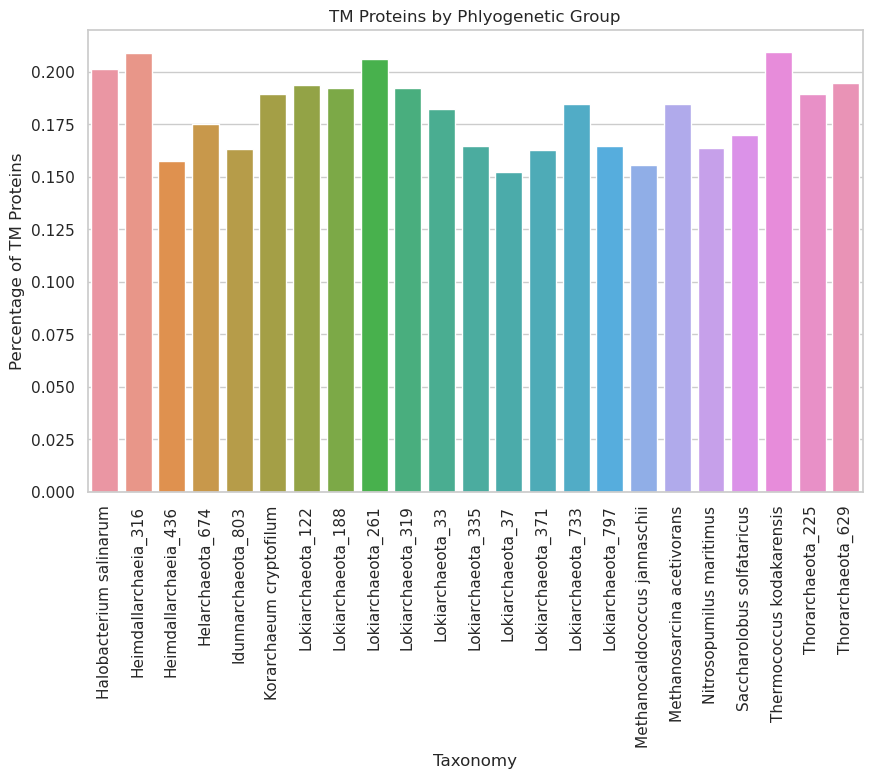

In [24]:
# Plot using Seaborn
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='Taxonomy', y='Percent_TMRs', data=grouped_data)
plt.title('TM Proteins by Phlyogenetic Group')
plt.xlabel('Taxonomy')
#rotate x-axis labels
plt.xticks(rotation=90)
plt.ylabel('Percentage of TM Proteins')
plt.show()


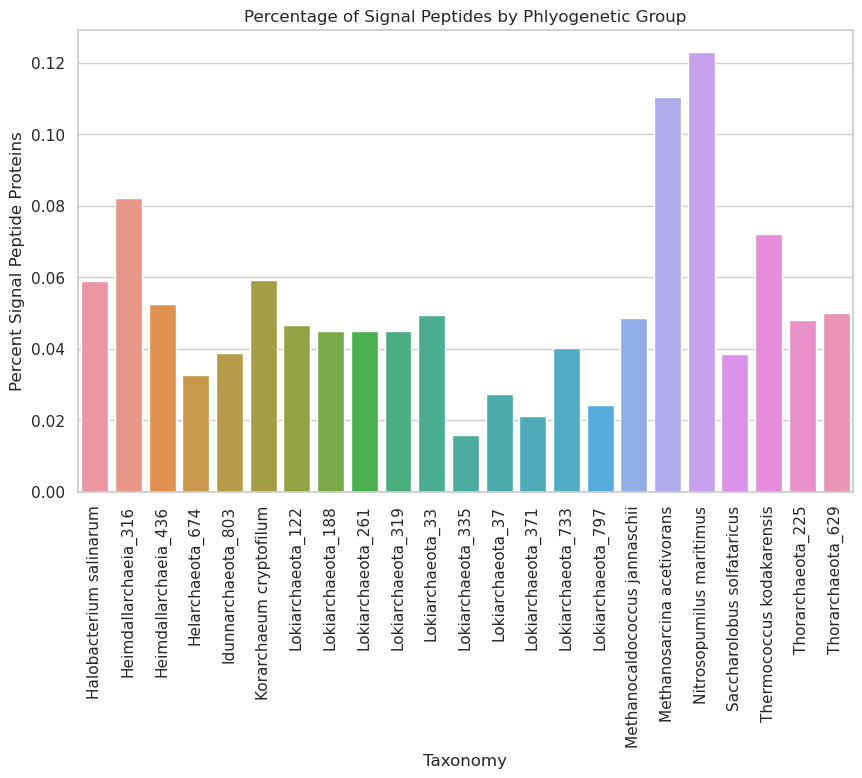

In [25]:
# Repeat with the signal peptide count
#grouped_data_signal = asgard.groupby('Taxonomy')['num_signal_tmbed'].apply(lambda x: (x != 0).sum()).reset_index(name='Number of Signal Peptide Proteins')

# Plot using Seaborn
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='Taxonomy', y='Percent_Signal', data=grouped_data)
plt.title('Percentage of Signal Peptides by Phlyogenetic Group')
plt.xlabel('Taxonomy')
#rotate x-axis labels
plt.xticks(rotation=90)
plt.ylabel('Percent Signal Peptide Proteins')
plt.show()

### Looking into the outliers

In [26]:
#Which of the proteins have more than 10 TM regions?
#make  copy of the dataframe
outliers = asgard 
#filter the dataframe to only include proteins with more than 10 TM regions
outliers = outliers[outliers['num_tm_residues_tmbed'] > 20]
outliers

,ProteinID,aa_sequence,tmbed_prediction,num_tm_residues_tmbed,num_signal_tmbed,Taxonomy
11773,D4994_C39_H1_Bin_319_scaffold_44375_2,FVIDYMALPDHEDLRIPEFNVWDGTERTYEYYLAEEFSAFKDVKIT...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,21,0,Lokiarchaeota_319
16124,D4994_C39_H1_Bin_188_scaffold_520423_1,MSPRLTNILQMGILFLKRLLLGLIATSILIVFYLDFELRILTSLII...,IIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMOOOOOOMMMMMMM...,85,0,Lokiarchaeota_188
18973,D4994_C39_H1_Bin_37_scaffold_341353_3,MTNISQSEEKLKKITEILWKYWWFVFYIIILPVGISLIISSVVIPY...,IIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMMM...,82,0,Lokiarchaeota_37
28610,D4994_C39_H1_Bin_674_scaffold_89833_1,PDSRKLYIITESILILNIFSILTLIYSISSFFIGLLISESLIISFI...,IIIIIIIMMMMMMMMMMMMMMMMMMMMMMMMMOOOOOMMMMMMMMM...,37,0,Helarchaeota_674
29384,D4994_C39_H1_Bin_261_scaffold_250881_1,MNYIHQDDNRKFLKVTNQLTDFAFILIFIIALPGIIGVVSAGITLL...,IIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMMMM...,62,0,Lokiarchaeota_261
30337,D4994_C39_H1_Bin_261_scaffold_424062_1,IFILEFLDVKIRREFSLASFTLGSILAGVFTYLILMEPVIFPETYW...,MMMMMIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMMOOOOOOOOO...,58,0,Lokiarchaeota_261
33130,D4994_C39_H1_Bin_122_scaffold_332122_4,MEKDDNSLKKRLNQLEEHIRTILSRLYHIETHLTNLNTFVKRVSPD...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,38,0,Lokiarchaeota_122
33389,D4994_C39_H1_Bin_122_scaffold_376061_1,TTFGLFLGSAFFFGTILAFQARHYLIKQFYEIVWFLMALFFGLSAF...,MMMMMMMMMMMMMMMMMMMMIIIIIIIIMMMMMMMMMMMMMMMMMM...,28,0,Lokiarchaeota_122
35587,D4994_C39_H1_Bin_371_scaffold_234488_6,MKSSGSENSQERIVKATESLWKILWFSLYIIVFPALVAIVFFFIFN...,IIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMO...,95,0,Lokiarchaeota_371
39731,D4994_C39_H1_Bin_316_scaffold_439998_5,MRDKKRKIILRVSLALVLLVFSLSAYGDEQTKIGIVTAQETNHHIV...,SSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOO...,21,1,Heimdallarchaeia_316


In [35]:
blorp = outliers[outliers['ProteinID'] == 'D4994_C39_H1_Bin_316_scaffold_439998_5']['tmbed_prediction']
blorp = blorp.to_string(index=False)
blorp

'SSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOO...'

##### Graph Distribution of TMRs among the Asgard phylas and connect the x-axis labels via phylogeny

In [1]:
# conda install -c etetoolkit ete3 <-- will need this toolkit to make this graph 
# wasn't working (ModuleNotFoundError) so ran ete3 build check on the command line
# Recommended to install the ete_toolchain: conda install -c etetoolkit ete_toolchain




In [3]:
# Create a sample DataFrame with species and their corresponding values
data = {'Species': ['Species A', 'Species B', 'Species C', 'Species D'],
        'Value': [20, 30, 15, 25]}

df = pd.DataFrame(data)

# Create a Newick string representing the phylogenetic tree
newick_tree = "(Species A,(Species B,(Species C,Species D)));"

# Load the phylogenetic tree
tree = Tree(newick_tree)

# Plot the phylogenetic tree
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.show()

: 

: 